# Terrain Slope Classification — Upgraded Training & Evaluation

**Focus**: No re-extraction, better split, ROI crop, tuned augmentation, fine-tuning, temporal smoothing

This notebook implements an advanced terrain slope classification pipeline with:
- Two-phase training (warm-up + fine-tuning)
- Group-aware data splitting by ride
- ROI-focused image preprocessing
- Conservative data augmentation
- Temporal smoothing for video sequences

## 🔧 Environment Setup

Setting up Google Colab environment and mounting Google Drive for data access.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 📚 Import Libraries

Importing all required libraries for data processing, machine learning, and visualization.

In [2]:
# Import required libraries
import os, random, math, warnings
from datetime import datetime
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set_palette("husl")

# ML/Deep Learning imports
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


## 🎲 Reproducibility Settings

Setting random seeds for reproducible results across different runs.

In [3]:
# Set reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Reproducibility settings applied")

✅ Reproducibility settings applied


## ⚙️ Configuration & Setup

Comprehensive configuration with error handling and compatibility checks for robust training pipeline.

In [4]:
# Configuration - UPDATED WITH ERROR FIXES
CONFIG = {
    # Data roots (same as your working setup)
    "BASE_DATA_PATH": "/content/drive/MyDrive/msc proj- data/June_3_25/Video_Telometry/",
    "BASE_OUTPUT_DIR": "/content/drive/MyDrive/msc proj- data/June_3_25/Preprocessed_All_Rides",

    # A fresh run output folder for this improved training
    "RUN_TAG": f"Model_Output_v2_ROI_FT_SMOOTH_{datetime.now().strftime('%Y-%m-%d_%H%M')}",
    "MODEL_OUTPUT_ROOT": "/content/drive/MyDrive/msc proj- data/June_3_25",

    # Image pipeline
    "IMG_SIZE": (224, 224),
    "CROP_TOP_FRAC": 0.35,    # keep lower 65% (focus on road/horizon)
    "CROP_BOTTOM_FRAC": 0.95, # cut off possible bike frame region if needed

    # Augmentation (conservative, slope-safe)
    "USE_AUGMENTATION": True,
    "AUG_HFLIP": True,
    "AUG_BRIGHTNESS_DELTA": 0.08,   # ±8%
    "AUG_CONTRAST_RANGE": (0.9, 1.10),
    "AUG_SATURATION_RANGE": (0.90, 1.10),
    "AUG_NOISE_STDDEV": 0.01,
    "AUG_ROT_DEG": 5.0,  # applied via RandomRotation layer inside the model

    # Train/Val split
    "VAL_SPLIT": 0.20,

    # Training schedule
    "BATCH_SIZE": 32,
    "EPOCHS_WARMUP": 8,
    "EPOCHS_FINETUNE": 20,
    "LR_WARMUP": 1e-3,
    "LR_FINETUNE": 3e-5,
    "EARLY_STOP_PATIENCE": 6,
    "DROPOUT": 0.30,
    "UNFREEZE_FRACTION_TOP": 0.40,  # unfreeze top 40% of MobileNetV2 layers

    # Smoothing
    "SMOOTH_WINDOW": 11,  # majority vote window (odd)
    "EMA_ALPHA": 0.7,     # for softmax EMA

    # Evaluation artifacts
    "MAX_EXAMPLES_PER_CLASS_REPORT": 1000
}

# Check TensorFlow version compatibility
tf_version = tf.__version__.split('.')
if int(tf_version[0]) < 2 or (int(tf_version[0]) == 2 and int(tf_version[1]) < 6):
    print(f"⚠️ TensorFlow {tf.__version__} detected. RandomRotation requires TF 2.6+")
    CONFIG["AUG_ROT_DEG"] = 0  # Disable rotation for older versions
    print("Rotation augmentation disabled for compatibility")

# Create run output directory
OUTPUT_DIR = os.path.join(CONFIG["MODEL_OUTPUT_ROOT"], CONFIG["RUN_TAG"])
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Output directory created: {OUTPUT_DIR}")

✅ Output directory created: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110


## 📊 Data Loading & Validation

Loading the master balanced dataset with comprehensive validation checks.

In [5]:
# Load master balanced dataset (with validation)
master_csv = os.path.join(CONFIG["BASE_OUTPUT_DIR"], "ALL_RIDES_labels_balanced.csv")

if not os.path.exists(master_csv):
    print(f"❌ Master dataset not found: {master_csv}")
    print("Please run data extraction/balancing first.")
    raise FileNotFoundError(f"Required file missing: {master_csv}")

df = pd.read_csv(master_csv)
expected_cols = {"frame_path", "label", "ride_name", "frame_index"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Expected columns missing from dataset: {missing}")

print(f"✅ Loaded master dataset: {len(df):,} samples from {df['ride_name'].nunique()} rides")
print("\nClass distribution:")
print(df.groupby("label").size().sort_index())

✅ Loaded master dataset: 4,934 samples from 13 rides

Class distribution:
label
flat             991
high_downhill    970
high_uphill      991
low_downhill     991
low_uphill       991
dtype: int64


## 🔀 Group-Aware Data Splitting

Creating train/validation splits by ride to prevent data leakage between different video sequences.

In [6]:
# Group-aware split by ride_name (prevents data leakage)
groups = df["ride_name"].values
labels = df["label"].values

# Ensure stratification indirectly by grouped split, then check label balance
gss = GroupShuffleSplit(n_splits=1, test_size=CONFIG["VAL_SPLIT"], random_state=SEED)
train_idx, val_idx = next(gss.split(df, y=labels, groups=groups))

# Validate split
if len(train_idx) == 0 or len(val_idx) == 0:
    raise ValueError("Empty train or validation split. Check your data distribution.")

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)

print("\n📊 Split summary (group-aware by ride):")
print(f"  Train: {len(train_df):,}  | rides: {train_df['ride_name'].nunique()}")
print(f"  Val:   {len(val_df):,}  | rides: {val_df['ride_name'].nunique()}")

print("\nLabel distribution (train):")
print(train_df["label"].value_counts().sort_index())
print("\nLabel distribution (val):")
print(val_df["label"].value_counts().sort_index())


📊 Split summary (group-aware by ride):
  Train: 3,864  | rides: 10
  Val:   1,070  | rides: 3

Label distribution (train):
label
flat             777
high_downhill    756
high_uphill      777
low_downhill     777
low_uphill       777
Name: count, dtype: int64

Label distribution (val):
label
flat             214
high_downhill    214
high_uphill      214
low_downhill     214
low_uphill       214
Name: count, dtype: int64


In [7]:
# Label encoding
le = LabelEncoder()
le.fit(df["label"])
train_df = train_df.copy()
val_df   = val_df.copy()
train_df["label_enc"] = le.transform(train_df["label"])
val_df["label_enc"]   = le.transform(val_df["label"])
n_classes = len(le.classes_)

print(f"\n🏷️ Classes ({n_classes}): {list(le.classes_)}")
print("✅ Label encoding completed")


🏷️ Classes (5): ['flat', 'high_downhill', 'high_uphill', 'low_downhill', 'low_uphill']
✅ Label encoding completed


## 🚀 TensorFlow Data Pipeline

Creating optimized data pipelines with ROI cropping, data augmentation, and memory-safe settings.

In [8]:
# tf.data pipeline with ROI crop and augmentation
IMG_H, IMG_W = CONFIG["IMG_SIZE"]

def _decode_and_crop(path):
    """Load image and apply ROI crop"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    # ROI crop (deterministic) - focus on road/horizon
    h = tf.shape(img)[0]
    top = tf.cast(tf.round(CONFIG["CROP_TOP_FRAC"] * tf.cast(h, tf.float32)), tf.int32)
    bottom = tf.cast(tf.round(CONFIG["CROP_BOTTOM_FRAC"] * tf.cast(h, tf.float32)), tf.int32)
    img = img[top:bottom, :, :]

    # Resize and normalize
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img, tf.float32) / 255.0
    return img

def _augment(img):
    """Apply conservative data augmentation"""
    if not CONFIG["USE_AUGMENTATION"]:
        return img

    if CONFIG["AUG_HFLIP"]:
        img = tf.image.random_flip_left_right(img)

    if CONFIG["AUG_BRIGHTNESS_DELTA"] > 0:
        img = tf.image.random_brightness(img, CONFIG["AUG_BRIGHTNESS_DELTA"])

    low, high = CONFIG["AUG_CONTRAST_RANGE"]
    img = tf.image.random_contrast(img, low, high)

    low_s, high_s = CONFIG["AUG_SATURATION_RANGE"]
    img = tf.image.random_saturation(img, low_s, high_s)

    if CONFIG["AUG_NOISE_STDDEV"] > 0:
        noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=CONFIG["AUG_NOISE_STDDEV"])
        img = tf.clip_by_value(img + noise, 0.0, 1.0)

    return img

def _load_example(path, label, training=True):
    """Load a single training example"""
    img = _decode_and_crop(path)
    if training:
        img = _augment(img)
    label = tf.cast(label, tf.int32)
    return img, label

def make_dataset(paths, labels, training=True, batch_size=32):
    """Create TensorFlow dataset with memory-safe settings"""
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, y: _load_example(p, y, training),
                num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        # Memory-safe shuffle buffer
        buffer_size = min(len(paths), 10000)
        ds = ds.shuffle(buffer_size=buffer_size, seed=SEED, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

print("✅ Data pipeline functions defined")

✅ Data pipeline functions defined


In [9]:
# Create training and validation datasets
train_paths = train_df["frame_path"].values
val_paths   = val_df["frame_path"].values
train_labels = train_df["label_enc"].values
val_labels   = val_df["label_enc"].values

train_ds = make_dataset(train_paths, train_labels, training=True,  batch_size=CONFIG["BATCH_SIZE"])
val_ds   = make_dataset(val_paths,   val_labels,   training=False, batch_size=CONFIG["BATCH_SIZE"])

print(f"✅ Datasets created:")
print(f"  Training samples: {len(train_paths):,}")
print(f"  Validation samples: {len(val_paths):,}")
print(f"  Batch size: {CONFIG['BATCH_SIZE']}")

✅ Datasets created:
  Training samples: 3,864
  Validation samples: 1,070
  Batch size: 32


## 🏗️ Model Architecture

Building MobileNetV2-based model with integrated data augmentation and transfer learning setup.

In [10]:
# Model architecture with optional RandomRotation preprocessing layer
def build_model(n_classes, input_shape=(224, 224, 3), dropout=0.30, rot_deg=5.0):
    """Build MobileNetV2-based model with integrated augmentation"""
    inputs = layers.Input(shape=input_shape)

    # Small rotation inside the model (applies in training only)
    if CONFIG["USE_AUGMENTATION"] and rot_deg and rot_deg > 0:
        rot_factor = float(rot_deg) / 180.0  # fraction of 180°
        try:
            x = layers.RandomRotation(factor=rot_factor, fill_mode="nearest")(inputs)
        except AttributeError:
            print("⚠️ RandomRotation not available, skipping rotation augmentation")
            x = inputs
    else:
        x = inputs

    # MobileNetV2 backbone
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    base.trainable = False  # Start with frozen backbone for warm-up phase

    x = base(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="slope_classifier_mnv2")
    return model, base

# Build model
model, base = build_model(
    n_classes=n_classes,
    input_shape=(*CONFIG["IMG_SIZE"], 3),
    dropout=CONFIG["DROPOUT"],
    rot_deg=CONFIG["AUG_ROT_DEG"]
)

print("✅ Model architecture created")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model architecture created


## 📐 Model Compilation & Summary

Compiling the model for warm-up phase with frozen backbone and displaying architecture summary.

In [11]:
# Compile model for warm-up phase
model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["LR_WARMUP"]),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top_2_accuracy")
    ]
)

print("\n📋 Model Summary (Warm-up phase, backbone frozen):")
model.summary()

print(f"\n✅ Model compiled for warm-up:")
print(f"  Learning rate: {CONFIG['LR_WARMUP']}")
print(f"  Backbone layers: {len(base.layers)} (all frozen)")


📋 Model Summary (Warm-up phase, backbone frozen):


Model: "slope_classifier_mnv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)


✅ Model compiled for warm-up:
  Learning rate: 0.001
  Backbone layers: 154 (all frozen)


In [12]:
# Setup callbacks
checkpoint_path = os.path.join(OUTPUT_DIR, "best_model.keras")
log_path        = os.path.join(OUTPUT_DIR, "training_log.csv")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=CONFIG["EARLY_STOP_PATIENCE"],
                  restore_best_weights=True, verbose=1, mode="min"),
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy", mode="max",
                    save_best_only=True, save_weights_only=False, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3,
                      min_lr=1e-7, mode="min", verbose=1),
    tf.keras.callbacks.CSVLogger(log_path, separator=",", append=False)
]

print("✅ Callbacks configured:")
print(f"  • Early Stopping (patience={CONFIG['EARLY_STOP_PATIENCE']})")
print(f"  • Model Checkpoint → {checkpoint_path}")
print(f"  • Learning Rate Reduction")
print(f"  • CSV Logger → {log_path}")

✅ Callbacks configured:
  • Early Stopping (patience=6)
  • Model Checkpoint → /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110/best_model.keras
  • Learning Rate Reduction
  • CSV Logger → /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110/training_log.csv


## 🔥 Phase A: Warm-up Training

Training with frozen backbone to learn task-specific features in the classifier head.

In [13]:
# Phase A — Warm-up training (frozen backbone)
print("\n🔥 === Phase A: Warm-up training (frozen backbone) ===")
print(f"Epochs: {CONFIG['EPOCHS_WARMUP']} | Learning Rate: {CONFIG['LR_WARMUP']}")
print("="*60)

hist_warm = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["EPOCHS_WARMUP"],
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Warm-up phase completed!")
print(f"Final train accuracy: {hist_warm.history['accuracy'][-1]:.4f}")
print(f"Final val accuracy: {hist_warm.history['val_accuracy'][-1]:.4f}")


🔥 === Phase A: Warm-up training (frozen backbone) ===
Epochs: 8 | Learning Rate: 0.001
Epoch 1/8
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3005 - loss: 1.8118 - top_2_accuracy: 0.5287
Epoch 1: val_accuracy improved from -inf to 0.38505, saving model to /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110/best_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 354s 512ms/step - accuracy: 0.3009 - loss: 1.8103 - top_2_accuracy: 0.5291 - val_accuracy: 0.3850 - val_loss: 1.5819 - val_top_2_accuracy: 0.5841 - learning_rate: 0.0010
Epoch 2/8
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4474 - loss: 1.3670 - top_2_accuracy: 0.6701
Epoch 2: val_accuracy improved from 0.38505 to 0.40000, saving model to /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110/best_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4473 - loss: 1.3669 - top_2_accuracy: 0.6702 - val_accuracy: 0.4000 - v

## 🎯 Phase B: Fine-tuning Preparation

Selectively unfreezing top layers of MobileNetV2 for fine-tuning at reduced learning rate.

In [14]:
# Phase B — Selective fine-tuning (unfreeze top MobileNetV2 layers)
print("\n🔧 Preparing for fine-tuning phase...")

# Unfreeze top fraction of layers
n_layers = len(base.layers)
if n_layers == 0:
    print("⚠️ No layers found in base model")
else:
    cut = max(0, int(n_layers * (1.0 - CONFIG["UNFREEZE_FRACTION_TOP"])))
    frozen_count = 0
    unfrozen_count = 0

    for li, layer in enumerate(base.layers):
        layer.trainable = (li >= cut)
        if layer.trainable:
            unfrozen_count += 1
        else:
            frozen_count += 1

    print(f"✅ Layer configuration updated:")
    print(f"  Total layers: {n_layers}")
    print(f"  Frozen: {frozen_count} | Unfrozen: {unfrozen_count}")
    print(f"  Unfrozen fraction: {unfrozen_count/n_layers:.2%}")

# Re-compile at lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["LR_FINETUNE"]),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top_2_accuracy")
    ]
)

print(f"\n🎯 Model recompiled for fine-tuning:")
print(f"  Learning rate: {CONFIG['LR_FINETUNE']} (reduced from {CONFIG['LR_WARMUP']})")


🔧 Preparing for fine-tuning phase...
✅ Layer configuration updated:
  Total layers: 154
  Frozen: 92 | Unfrozen: 62
  Unfrozen fraction: 40.26%

🎯 Model recompiled for fine-tuning:
  Learning rate: 3e-05 (reduced from 0.001)


In [15]:
# Phase B — Fine-tuning training
print("\n🚀 === Phase B: Fine-tuning training ===")
print(f"Epochs: {CONFIG['EPOCHS_FINETUNE']} | Learning Rate: {CONFIG['LR_FINETUNE']}")
print(f"Unfrozen top {CONFIG['UNFREEZE_FRACTION_TOP']:.0%} of MobileNetV2 layers")
print("="*60)

hist_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["EPOCHS_FINETUNE"],
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Fine-tuning phase completed!")
print(f"Final train accuracy: {hist_ft.history['accuracy'][-1]:.4f}")
print(f"Final val accuracy: {hist_ft.history['val_accuracy'][-1]:.4f}")


🚀 === Phase B: Fine-tuning training ===
Epochs: 20 | Learning Rate: 3e-05
Unfrozen top 40% of MobileNetV2 layers
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3366 - loss: 1.7378 - top_2_accuracy: 0.5743
Epoch 1: val_accuracy did not improve from 0.46168
121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - accuracy: 0.3369 - loss: 1.7370 - top_2_accuracy: 0.5747 - val_accuracy: 0.4075 - val_loss: 1.6517 - val_top_2_accuracy: 0.6028 - learning_rate: 3.0000e-05
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4511 - loss: 1.3630 - top_2_accuracy: 0.6952
Epoch 2: val_accuracy did not improve from 0.46168
121/121 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.4513 - loss: 1.3629 - top_2_accuracy: 0.6952 - val_accuracy: 0.3822 - val_loss: 1.7460 - val_top_2_accuracy: 0.6056 - learning_rate: 3.0000e-05
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5190 - loss: 1.1889 - top_2_accuracy: 0.7660
Epoch 3: val_accuracy did not improve from 0.

## 📊 Training Visualization

Creating comprehensive training history plots showing both warm-up and fine-tuning phases.


📊 Creating training history visualizations...


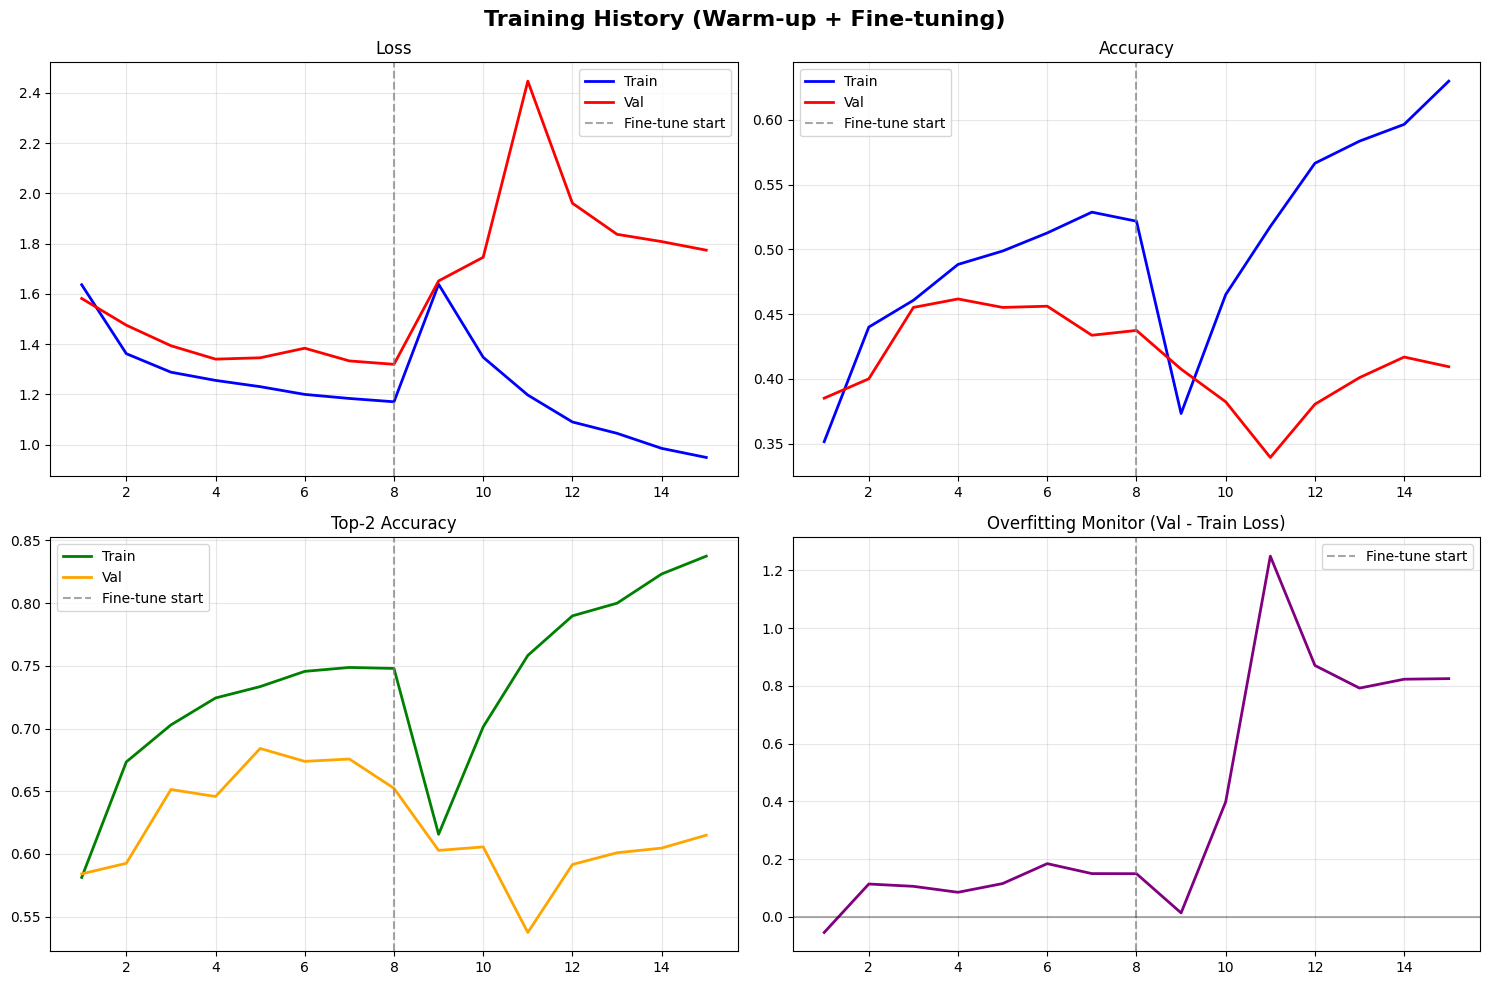

✅ Saved: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110/training_history.png


In [16]:
# Merge training histories and create plots
print("\n📊 Creating training history visualizations...")

# Merge histories for plotting
history = {
    k: hist_warm.history.get(k, []) + hist_ft.history.get(k, [])
    for k in set(list(hist_warm.history.keys()) + list(hist_ft.history.keys()))
}

def plot_history(history_dict, save_path):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Training History (Warm-up + Fine-tuning)", fontsize=16, fontweight="bold")

    epochs = range(1, len(history_dict["loss"]) + 1)
    warmup_end = CONFIG["EPOCHS_WARMUP"]

    # Loss plot
    axes[0,0].plot(epochs, history_dict["loss"], 'b-', label="Train", linewidth=2)
    axes[0,0].plot(epochs, history_dict["val_loss"], 'r-', label="Val", linewidth=2)
    axes[0,0].axvline(x=warmup_end, color='gray', linestyle='--', alpha=0.7, label='Fine-tune start')
    axes[0,0].set_title("Loss")
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0,1].plot(epochs, history_dict["accuracy"], 'b-', label="Train", linewidth=2)
    axes[0,1].plot(epochs, history_dict["val_accuracy"], 'r-', label="Val", linewidth=2)
    axes[0,1].axvline(x=warmup_end, color='gray', linestyle='--', alpha=0.7, label='Fine-tune start')
    axes[0,1].set_title("Accuracy")
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Top-2 accuracy (if available)
    if "top_2_accuracy" in history_dict and "val_top_2_accuracy" in history_dict:
        axes[1,0].plot(epochs, history_dict["top_2_accuracy"], 'g-', label="Train", linewidth=2)
        axes[1,0].plot(epochs, history_dict["val_top_2_accuracy"], 'orange', label="Val", linewidth=2)
        axes[1,0].axvline(x=warmup_end, color='gray', linestyle='--', alpha=0.7, label='Fine-tune start')
        axes[1,0].set_title("Top-2 Accuracy")
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].text(0.5, 0.5, 'Top-2 Accuracy\nNot Available',
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title("Top-2 Accuracy")

    # Overfitting monitor
    diff = [v - t for t, v in zip(history_dict["loss"], history_dict["val_loss"])]
    axes[1,1].plot(epochs, diff, 'purple', linewidth=2)
    axes[1,1].axvline(x=warmup_end, color='gray', linestyle='--', alpha=0.7, label='Fine-tune start')
    axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1,1].set_title("Overfitting Monitor (Val - Train Loss)")
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved: {save_path}")

# Create training history plot
plot_history(history, os.path.join(OUTPUT_DIR, "training_history.png"))

## 📈 Model Evaluation - Raw Performance

Evaluating the trained model on validation set with per-frame metrics and detailed classification report.

In [17]:
# Raw evaluation (per-frame)
def evaluate_raw(model, val_ds, label_encoder):
    """Evaluate model on validation set (per-frame basis)"""
    print("🔍 Evaluating model (per-frame)...")

    y_true = np.concatenate([y for _, y in val_ds], axis=0)
    y_prob = model.predict(val_ds, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")
    top2 = np.mean([
        yt in np.argsort(pp)[-2:] for yt, pp in zip(y_true, y_prob)
    ])

    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_true, y_pred)

    return {
        "y_true": y_true, "y_pred": y_pred, "y_prob": y_prob,
        "acc": acc, "f1_macro": f1m, "f1_weighted": f1w, "top2": top2,
        "report_text": report, "cm": cm
    }

# Perform raw evaluation
raw_eval = evaluate_raw(model, val_ds, le)

print("\n📈 Raw validation metrics (per-frame):")
print(f"  Accuracy:      {raw_eval['acc']:.4f} ({raw_eval['acc']*100:.2f}%)")
print(f"  F1 (macro):    {raw_eval['f1_macro']:.4f}")
print(f"  F1 (weighted): {raw_eval['f1_weighted']:.4f}")
print(f"  Top-2 Acc:     {raw_eval['top2']:.4f} ({raw_eval['top2']*100:.2f}%)")

print("\n📋 Detailed Classification Report:")
print(raw_eval["report_text"])

🔍 Evaluating model (per-frame)...
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step

📈 Raw validation metrics (per-frame):
  Accuracy:      0.4075 (40.75%)
  F1 (macro):    0.3619
  F1 (weighted): 0.3619
  Top-2 Acc:     0.6028 (60.28%)

📋 Detailed Classification Report:
               precision    recall  f1-score   support

         flat       0.33      0.15      0.21       214
high_downhill       0.33      0.59      0.42       214
  high_uphill       0.50      0.88      0.64       214
 low_downhill       0.79      0.14      0.24       214
   low_uphill       0.33      0.28      0.30       214

     accuracy                           0.41      1070
    macro avg       0.46      0.41      0.36      1070
 weighted avg       0.46      0.41      0.36      1070



## 🎭 Confusion Matrix Visualization

Creating and displaying confusion matrices (raw counts and normalized) for detailed error analysis.

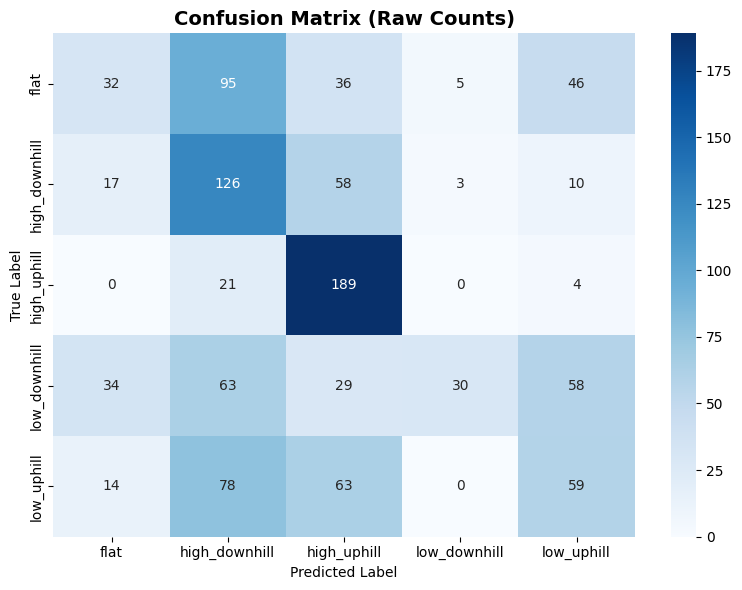

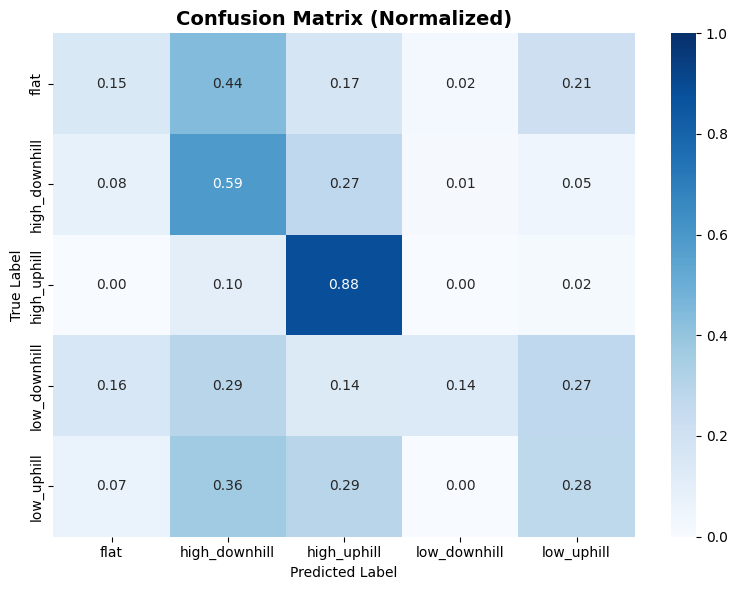

✅ Confusion matrices saved:
  Raw: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110/confusion_matrix_raw.png
  Normalized: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110/confusion_matrix_normalized.png


In [18]:
# Create and save confusion matrices
def plot_confusion_matrices(cm, classes, output_dir):
    """Plot and save confusion matrices (raw and normalized)"""

    # Raw confusion matrix
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix (Raw Counts)", fontsize=14, fontweight='bold')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    raw_path = os.path.join(output_dir, "confusion_matrix_raw.png")
    plt.savefig(raw_path, dpi=300, bbox_inches="tight")
    plt.show()

    # Normalized confusion matrix
    cmn = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes, yticklabels=classes, vmin=0, vmax=1)
    plt.title("Confusion Matrix (Normalized)", fontsize=14, fontweight='bold')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    norm_path = os.path.join(output_dir, "confusion_matrix_normalized.png")
    plt.savefig(norm_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Confusion matrices saved:")
    print(f"  Raw: {raw_path}")
    print(f"  Normalized: {norm_path}")

# Plot confusion matrices
plot_confusion_matrices(raw_eval["cm"], le.classes_, OUTPUT_DIR)

## 🎬 Temporal Smoothing

Implementing and evaluating temporal smoothing techniques for sequential video data.

In [19]:
# Temporal smoothing functions
def majority_vote(seq_preds, k=11):
    """Apply majority vote smoothing with sliding window"""
    assert k % 2 == 1, "Window k must be odd."
    half = k // 2
    out = []
    for i in range(len(seq_preds)):
        s = max(0, i - half)
        e = min(len(seq_preds), i + half + 1)
        window = seq_preds[s:e]
        vals, counts = np.unique(window, return_counts=True)
        out.append(vals[np.argmax(counts)])
    return np.array(out)

def ema_smooth_probs(prob_seq, alpha=0.7):
    """Apply exponential moving average to probability sequences"""
    ema = np.zeros_like(prob_seq[0])
    out = []
    for p in prob_seq:
        ema = alpha * ema + (1.0 - alpha) * p
        ema = ema / (np.sum(ema) + 1e-9)  # Avoid division by zero
        out.append(ema.copy())
    return np.array(out)

print("✅ Temporal smoothing functions defined")

✅ Temporal smoothing functions defined


In [20]:
# Temporal smoothing evaluation (per-ride sequential)
def evaluate_with_smoothing(model, val_df, label_encoder, batch_size=32, window=11, alpha=0.7):
    """Evaluate model with temporal smoothing on sequential ride data"""
    print(f"\n🎬 Evaluating with temporal smoothing...")
    print(f"  Majority vote window: {window} frames")
    print(f"  EMA alpha: {alpha}")

    # Sort by ride then frame_index to recover temporal order
    ordered = val_df.sort_values(["ride_name", "frame_index"]).reset_index(drop=True)
    paths = ordered["frame_path"].values
    y_true = ordered["label_enc"].values
    rides  = ordered["ride_name"].values

    # Build an ordered dataset (no shuffle)
    def ds_from_paths(paths, labels):
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(lambda p, y: (_decode_and_crop(p), tf.cast(y, tf.int32)),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

    ds_seq = ds_from_paths(paths, y_true)
    y_prob = model.predict(ds_seq, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    # Apply smoothing per ride
    y_pred_mv = np.empty_like(y_pred)
    y_pred_ema = np.empty_like(y_pred)

    for r in np.unique(rides):
        idx = np.where(rides == r)[0]
        p_seq  = y_prob[idx]
        y_seq  = y_pred[idx]

        # Apply majority vote
        y_pred_mv[idx] = majority_vote(y_seq, k=window)

        # Apply EMA smoothing
        ema_probs = ema_smooth_probs(p_seq, alpha=alpha)
        y_pred_ema[idx] = np.argmax(ema_probs, axis=1)

    # Calculate metrics for each approach
    metrics = {}
    for name, yp in [("raw_seq", y_pred), ("majority_vote", y_pred_mv), ("ema_smooth", y_pred_ema)]:
        acc = accuracy_score(y_true, yp)
        f1m = f1_score(y_true, yp, average="macro")
        f1w = f1_score(y_true, yp, average="weighted")
        metrics[name] = {"acc": acc, "f1_macro": f1m, "f1_weighted": f1w}

    return metrics

# Perform temporal smoothing evaluation
smooth_metrics = evaluate_with_smoothing(
    model, val_df, le,
    batch_size=CONFIG["BATCH_SIZE"],
    window=CONFIG["SMOOTH_WINDOW"],
    alpha=CONFIG["EMA_ALPHA"]
)

print("\n🎯 Temporal smoothing evaluation results:")
print("=" * 60)
for method, metrics in smooth_metrics.items():
    print(f"{method:>12} → acc={metrics['acc']:.4f} ({metrics['acc']*100:.2f}%), "
          f"f1_macro={metrics['f1_macro']:.4f}, f1_weighted={metrics['f1_weighted']:.4f}")

# Calculate improvements
raw_acc = smooth_metrics['raw_seq']['acc']
mv_acc = smooth_metrics['majority_vote']['acc']
ema_acc = smooth_metrics['ema_smooth']['acc']

print(f"\n📊 Smoothing improvements:")
print(f"  Majority vote: +{(mv_acc - raw_acc)*100:.2f}% accuracy")
print(f"  EMA smoothing: +{(ema_acc - raw_acc)*100:.2f}% accuracy")


🎬 Evaluating with temporal smoothing...
  Majority vote window: 11 frames
  EMA alpha: 0.7
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step

🎯 Temporal smoothing evaluation results:
     raw_seq → acc=0.4075 (40.75%), f1_macro=0.3619, f1_weighted=0.3619
majority_vote → acc=0.4056 (40.56%), f1_macro=0.3596, f1_weighted=0.3596
  ema_smooth → acc=0.4028 (40.28%), f1_macro=0.3575, f1_weighted=0.3575

📊 Smoothing improvements:
  Majority vote: +-0.19% accuracy
  EMA smoothing: +-0.47% accuracy


## 📄 Final Report Generation

Creating comprehensive report with all training details, performance metrics, and generated artifacts.

In [21]:
# Generate comprehensive final report
print("\n📄 Generating final report...")

report_path = os.path.join(OUTPUT_DIR, "FINAL_TRAINING_REPORT.txt")
with open(report_path, "w") as f:
    f.write("SLOPE CLASSIFICATION — UPGRADED TRAINING REPORT\n")
    f.write("="*72 + "\n\n")

    # Run info
    f.write(f"Run Tag: {CONFIG['RUN_TAG']}\n")
    f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"TensorFlow Version: {tf.__version__}\n\n")

    # Data info
    f.write("DATA SUMMARY\n")
    f.write("-" * 20 + "\n")
    f.write(f"Master CSV: {master_csv}\n")
    f.write(f"Train samples: {len(train_df):,} | rides: {train_df['ride_name'].nunique()}\n")
    f.write(f"Val samples:   {len(val_df):,}   | rides: {val_df['ride_name'].nunique()}\n")
    f.write(f"Total classes: {n_classes}\n")
    f.write(f"Classes: {', '.join(le.classes_)}\n\n")

    # Model architecture
    f.write("MODEL ARCHITECTURE\n")
    f.write("-" * 20 + "\n")
    f.write("Backbone: MobileNetV2 (ImageNet pretrained)\n")
    f.write(f"Input size: {CONFIG['IMG_SIZE']}\n")
    f.write(f"ROI crop: top {CONFIG['CROP_TOP_FRAC']:.1%}, bottom {CONFIG['CROP_BOTTOM_FRAC']:.1%}\n")
    f.write(f"Dropout: {CONFIG['DROPOUT']}\n")
    f.write(f"Augmentation: {CONFIG['USE_AUGMENTATION']}\n\n")

    # Training schedule
    f.write("TRAINING SCHEDULE\n")
    f.write("-" * 20 + "\n")
    f.write(f"Phase A (Warm-up): {CONFIG['EPOCHS_WARMUP']} epochs | LR: {CONFIG['LR_WARMUP']} | Backbone frozen\n")
    f.write(f"Phase B (Fine-tune): {CONFIG['EPOCHS_FINETUNE']} epochs | LR: {CONFIG['LR_FINETUNE']} | Top {CONFIG['UNFREEZE_FRACTION_TOP']:.1%} unfrozen\n")
    f.write(f"Batch size: {CONFIG['BATCH_SIZE']}\n")
    f.write(f"Early stopping patience: {CONFIG['EARLY_STOP_PATIENCE']}\n\n")

    # Results
    f.write("EVALUATION RESULTS\n")
    f.write("-" * 20 + "\n")
    f.write("Per-frame validation (raw):\n")
    f.write(f"  Accuracy:      {raw_eval['acc']:.4f} ({raw_eval['acc']*100:.2f}%)\n")
    f.write(f"  F1-macro:      {raw_eval['f1_macro']:.4f}\n")
    f.write(f"  F1-weighted:   {raw_eval['f1_weighted']:.4f}\n")
    f.write(f"  Top-2 accuracy: {raw_eval['top2']:.4f} ({raw_eval['top2']*100:.2f}%)\n\n")

    f.write("Temporal smoothing (per-ride sequential):\n")
    for method, metrics in smooth_metrics.items():
        f.write(f"  {method:>12} → acc={metrics['acc']:.4f} ({metrics['acc']*100:.2f}%), "
                f"f1_macro={metrics['f1_macro']:.4f}, f1_weighted={metrics['f1_weighted']:.4f}\n")

    # Artifacts
    f.write("\nGENERATED ARTIFACTS\n")
    f.write("-" * 20 + "\n")
    f.write(f"Best model:           {checkpoint_path}\n")
    f.write(f"Training history:     {os.path.join(OUTPUT_DIR, 'training_history.png')}\n")
    f.write(f"Confusion matrix:     {os.path.join(OUTPUT_DIR, 'confusion_matrix_raw.png')}\n")
    f.write(f"Confusion matrix norm: {os.path.join(OUTPUT_DIR, 'confusion_matrix_normalized.png')}\n")
    f.write(f"Training log:         {log_path}\n")
    f.write(f"This report:          {report_path}\n")

print(f"✅ Final report saved: {report_path}")

# Summary for user
print("\n" + "="*80)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"🎯 Best validation accuracy: {raw_eval['acc']:.4f} ({raw_eval['acc']*100:.2f}%)")
print(f"🔄 With majority vote smoothing: {smooth_metrics['majority_vote']['acc']:.4f} ({smooth_metrics['majority_vote']['acc']*100:.2f}%)")
print(f"📈 Improvement: +{(smooth_metrics['majority_vote']['acc'] - raw_eval['acc'])*100:.2f}%")
print("\n🎊 Ready for deployment!")
print("="*80)


📄 Generating final report...
✅ Final report saved: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110/FINAL_TRAINING_REPORT.txt

🎉 TRAINING COMPLETED SUCCESSFULLY!
📁 Output directory: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output_v2_ROI_FT_SMOOTH_2025-08-27_1110
🎯 Best validation accuracy: 0.4075 (40.75%)
🔄 With majority vote smoothing: 0.4056 (40.56%)
📈 Improvement: +-0.19%

🎊 Ready for deployment!
